In [2]:
import tensorflow_datasets as tfds

# Charger le dataset Malaria
dataset_name = "malaria"
data, info = tfds.load(dataset_name, with_info=True, as_supervised=True)

# Explorer les splits du dataset
train_data = data['train']

# Afficher des informations sur le dataset
print(info)


tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Utilisateur\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection 

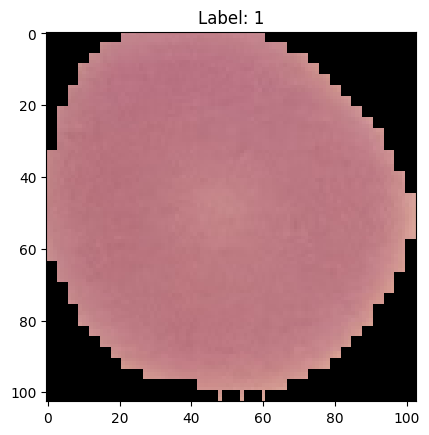

In [3]:
import matplotlib.pyplot as plt

# Exemple de visualisation
for image, label in train_data.take(1):
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.show()


In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Charger le dataset
dataset, info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)

# Fractionner en 80% train, 20% test
train_size = int(0.8 * info.splits['train'].num_examples)
test_size = info.splits['train'].num_examples - train_size

# Shuffle et split
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Vérifiez la taille
print(f"Train size: {train_size}, Test size: {test_size}")

# Prétraitement (normalisation et redimensionnement)
def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])  # Redimensionner à 128x128
    image = tf.cast(image, tf.float32) / 255.0  # Normaliser entre 0 et 1
    return image, label

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
# Visualiser un batch
for images, labels in train_dataset.take(1):
    print(f"Batch image shape: {images.shape}")
    print(f"Batch labels: {labels.numpy()}")



Train size: 22046, Test size: 5512
Batch image shape: (32, 128, 128, 3)
Batch labels: [1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1]


Création du modèle


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(128, 128, 3), num_classes=2):
    model = models.Sequential([
        # Étape de data augmentation
        layers.RandomFlip("horizontal", input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        
        # Couches convolutionnelles
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Sortie pour 2 classes
    ])
    
    # Compiler le modèle
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # Utilisé pour des labels entiers (0 ou 1)
        metrics=['accuracy']
    )
    
    return model

# Créer le modèle
cnn_model = create_cnn_model()

# Afficher le résumé du modèle
cnn_model.summary()


C:\Users\Utilisateur\PycharmProjects\Paludisme\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Charger les données (train_dataset, test_dataset préparés auparavant)
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Ou 'val_accuracy', selon votre priorité
    patience=3,          # Arrête l'entraînement si aucune amélioration pendant 3 époques
    restore_best_weights=True  # Récupère les poids de la meilleure époque
)

history = cnn_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,  # Utilisez un nombre élevé pour laisser l'early stopping décider
    callbacks=[early_stopping]
)

# Évaluer le modèle
test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 183s 263ms/step - accuracy: 0.7433 - loss: 0.4865 - val_accuracy: 0.9403 - val_loss: 0.1741
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 181s 263ms/step - accuracy: 0.9427 - loss: 0.1815 - val_accuracy: 0.9497 - val_loss: 0.1576
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 187s 272ms/step - accuracy: 0.9517 - loss: 0.1552 - val_accuracy: 0.9563 - val_loss: 0.1469
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 183s 265ms/step - accuracy: 0.9559 - loss: 0.1380 - val_accuracy: 0.9561 - val_loss: 0.1449
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 185s 269ms/step - accuracy: 0.9574 - loss: 0.1353 - val_accuracy: 0.9554 - val_loss: 0.1429
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 186s 269ms/step - accuracy: 0.9587 - loss: 0.1289 - val_accuracy: 0.9563 - val_loss: 0.1345
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 213s 309ms/step - accuracy: 0.9590 - loss: 0.1288 - val_accuracy: 0.9577 - val_loss: 0.1535
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 188s 273ms/step - accuracy: 0.9586 -

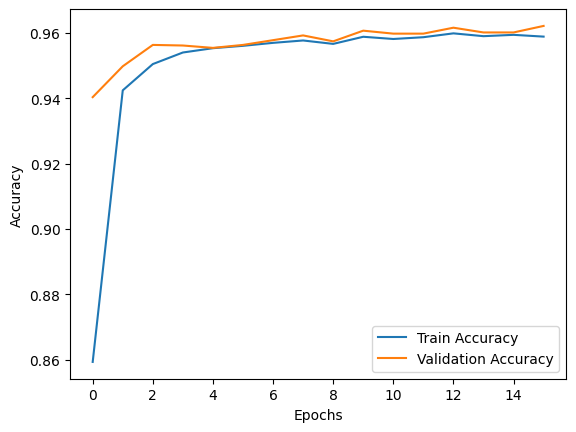

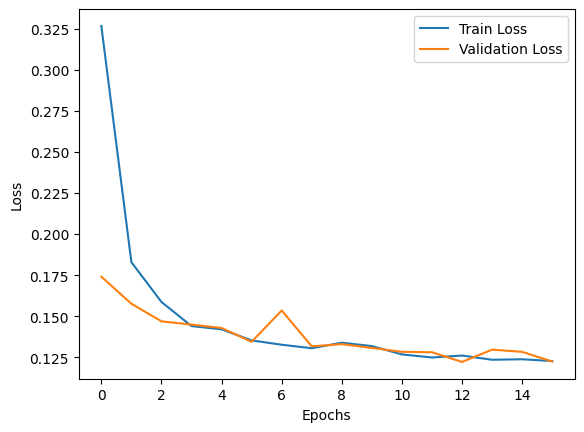

In [23]:
import matplotlib.pyplot as plt

# Courbe d'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbe de loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [26]:
# Sauvegarder le modèle en utilisant le format SavedModel
cnn_model.save('cnn_model.keras')



In [ ]:
# Import nécessaire
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
cnn_model=load_model('cnn_model.keras')
# Prédictions sur les données de test
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Ajouter les vraies étiquettes
    preds = cnn_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Convertir les probabilités en classes

# Convertir en arrays pour compatibilité avec sklearn
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Définir les noms des classes
class_names = ['Infecté', 'Non infecté']

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice avec sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion')
plt.show()

from sklearn.metrics import classification_report

# Rapport de classification
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━